In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset

# torchdiffeq 라이브러리 설치 후 사용 (pip install torchdiffeq)
from torchdiffeq import odeint

In [6]:
#############################
# 1. 데이터셋 정의
#############################


class PKPDataset(Dataset):
    """
    정적 특성("BW", "EGFR", "SEX", "RAAS", "BPS", "amt", "II")와
    시간(time), CP 값을 반환하며, 투여 이벤트는 amt와 II를 이용해 생성함.
    단, 단일 Parquet 파일("../processed_data.parquet")에서 각 환자별 데이터를 읽어옴.
    max_files: 전체 데이터 중 사용할 행 수 제한 (즉, 몇 개의 환자 데이터를 사용할지)
    max_rows: 각 샘플의 CP 시퀀스 길이 제한 (즉, CP 값의 몇 번째 값까지만 사용할지)
    """

    def __init__(
        self,
        parquet_path="../processed_data.parquet",
        transform=None,
        max_files=None,
        max_rows=None,
    ):
        # 단일 Parquet 파일에서 데이터프레임 로드
        self.df = pd.read_parquet(parquet_path, engine="pyarrow")
        # max_files가 지정되어 있으면 해당 행까지만 사용
        if max_files is not None:
            self.df = self.df.iloc[:max_files]
        self.transform = transform
        self.max_rows = max_rows

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 정적 특성 추출 (dtype: float32)
        static_features = (
            row[["BW", "EGFR", "SEX", "RAAS", "BPS", "amt", "II"]]
            .astype(np.float32)
            .values
        )
        static_features = torch.tensor(static_features)

        # t=1부터 시작하는 CP 시퀀스 추출 (t=0은 CP=0이므로 저장하지 않음)
        cp_sequence = np.array(row["CP_sequence"], dtype=np.float32)
        # max_rows가 지정되어 있으면 cp_sequence를 해당 길이까지만 사용
        if self.max_rows is not None:
            cp_sequence = cp_sequence[: self.max_rows]
        t_values = np.arange(0, len(cp_sequence), dtype=np.float32)
        t = torch.tensor(t_values)
        cp = torch.tensor(cp_sequence, dtype=torch.float32).unsqueeze(1)

        # amt와 II를 이용해 투여 이벤트 생성
        amt = static_features[5].item()
        II = static_features[6].item()
        total_time = t[-1].item()
        injection_times = np.arange(0, total_time + 1e-3, II, dtype=np.float32)
        injection_times = torch.tensor(injection_times, dtype=torch.float32)
        injection_doses = torch.full(injection_times.shape, amt, dtype=torch.float32)

        sample = {
            "static_features": static_features,  # (7,)
            "t": t,  # (T,)
            "cp": cp,  # (T, 1)
            "injection_times": injection_times,  # (n_events,)
            "injection_doses": injection_doses,  # (n_events,)
        }
        if self.transform:
            sample = self.transform(sample)
        return sample


def collate_fn(batch):
    """
    batch 내의 각 sample의 t, injection_times 등이 모두 동일한 길이라고 가정.
    """
    static_features = torch.stack(
        [b["static_features"] for b in batch], dim=0
    )  # (B, 7)
    t = batch[0]["t"]  # (T,)
    cp = torch.stack([b["cp"] for b in batch], dim=0)  # (B, T, 1)
    injection_times = torch.stack(
        [b["injection_times"] for b in batch], dim=0
    )  # (B, n_events)
    injection_doses = torch.stack(
        [b["injection_doses"] for b in batch], dim=0
    )  # (B, n_events)
    return {
        "static_features": static_features,
        "t": t,
        "cp": cp,
        "injection_times": injection_times,
        "injection_doses": injection_doses,
    }


#############################
# 2. 모델 정의 (Neural ODE)
#############################
class ODEF(nn.Module):
    """
    Neural ODE에서 사용될 ODE 함수.
    입력으로 현재 상태(state), 정적 임베딩(static_embed)와
    t시점에서의 투여 이벤트(투여 이벤트는 injection_times, injection_doses로 주어짐)를 반영하여
    미분값(dstate/dt)을 계산.
    """

    def __init__(self, hidden_dim, static_dim, dose_dim=1):
        super(ODEF, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim + static_dim + dose_dim, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim),
        )

    def forward(
        self, t, state, static_embed, injection_times, injection_doses, sigma=1.0
    ):
        # t는 스칼라 텐서, injection_times: (B, n_events), injection_doses: (B, n_events)
        # 각 배치별로 t와 injection_times의 차이를 계산하여 가우시안 커널로 근사한 투여값 계산
        # dose: (B, 1)
        dose = (
            injection_doses * torch.exp(-((t - injection_times) ** 2) / (2 * sigma**2))
        ).sum(dim=1, keepdim=True)
        dose = torch.clamp(dose, min=0.0, max=1e2)
        inp = torch.cat([state, static_embed, dose], dim=-1)
        return self.net(inp)


class NeuralODEModel(nn.Module):
    """
    전체 모델:
    - 정적 특성은 간단한 피드포워드 네트워크(static_encoder)로 임베딩.
    - 초기 상태 h0는 static_embed로부터 얻으며,
    - ODE 함수(ODEF)를 torchdiffeq.odeint로 풀어 시계열 은닉상태 h(t)를 얻고,
    - 최종 readout 레이어로 각 시점의 CP 값을 예측.
    """

    def __init__(self, static_input_dim=7, static_hidden_dim=16, ode_hidden_dim=16):
        super(NeuralODEModel, self).__init__()
        self.static_encoder = nn.Sequential(
            nn.Linear(static_input_dim, static_hidden_dim), nn.ReLU()
        )
        self.initial_state_layer = nn.Linear(static_hidden_dim, ode_hidden_dim)
        self.ode_func = ODEF(ode_hidden_dim, static_hidden_dim, dose_dim=1)
        self.readout = nn.Linear(ode_hidden_dim, 1)

    def forward(self, t, static_features, injection_times, injection_doses):
        """
        t: (T,) – 통합할 시간 벡터
        static_features: (B, 7)
        injection_times: (B, n_events)
        injection_doses: (B, n_events)
        """
        # 정적 특성 임베딩
        static_embed = self.static_encoder(static_features)  # (B, static_hidden_dim)
        # 초기 ODE 상태 h0 (배치별)
        h0 = self.initial_state_layer(static_embed)  # (B, ode_hidden_dim)

        # ODE 함수 정의 (추가 인자로 static_embed, injection_times, injection_doses 전달)
        def func(t_val, h):
            return self.ode_func(
                t_val, h, static_embed, injection_times, injection_doses
            )

        # ODE 풀기 (rk4 방법 사용)
        # odeint 출력: (T, B, ode_hidden_dim)
        h_t = odeint(func, h0, t, method="rk4")
        h_t = h_t.transpose(0, 1)  # (B, T, ode_hidden_dim)
        cp_pred = self.readout(h_t)  # (B, T, 1)
        return cp_pred


#############################
# 3. Inference 함수
#############################
def run_inference(
    model, static_features, injection_times, injection_doses, total_time, device
):
    """
    기존 모델을 불러와서 사용자 입력(정적 특성, 투여 이벤트, 총 측정시간)에 따라
    시간에 따른 CP 값을 예측한 후, CSV 파일 및 차트 이미지(predicted_cp.png)를 생성.

    인자:
      - static_features: 리스트 또는 np.array, shape (7,)
      - injection_times: 리스트 또는 np.array, shape (n_events,)
      - injection_doses: 리스트 또는 np.array, shape (n_events,)
      - total_time: 총 측정 시간 (스칼라)
    """
    # 예측할 시간 벡터 (여기서는 1시간 간격으로 샘플링)
    # 수정 후: t를 1부터 total_time까지로 설정 (총 T time steps)
    T = int(total_time) + 1
    t = torch.linspace(0, total_time, steps=T).to(device)
    static_features = (
        torch.tensor(static_features, dtype=torch.float32).unsqueeze(0).to(device)
    )  # (1, 7)
    injection_times = (
        torch.tensor(injection_times, dtype=torch.float32).unsqueeze(0).to(device)
    )  # (1, n_events)
    injection_doses = (
        torch.tensor(injection_doses, dtype=torch.float32).unsqueeze(0).to(device)
    )  # (1, n_events)

    model.eval()
    with torch.no_grad():
        cp_pred = model(
            t, static_features, injection_times, injection_doses
        )  # (1, T, 1)
    cp_pred = cp_pred.squeeze().cpu().numpy()  # (T,)

    # 예측 데이터를 CSV로 저장
    pred_df = pd.DataFrame({"time": t.cpu().numpy(), "CP_pred": cp_pred})
    pred_df.to_csv("predicted_cp.csv", index=False)

    # 차트 생성 및 저장
    plt.figure()
    plt.plot(t.cpu().numpy(), cp_pred, marker=".")
    plt.xlabel("Time")
    plt.ylabel("CP")
    plt.title("Predicted CP over Time")
    plt.savefig("predicted_cp.png")
    plt.close()
    print("Inference 완료: predicted_cp.csv, predicted_cp.png 생성됨.")
    return cp_pred

C:\Users\yeohj\AppData\Local\Temp\ipykernel_8312\2507741726.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

선택한 모드: test_infer
체크포인트 불러옴: epoch 150부터 이어서 학습합니다.
첫 5개의 행의 CP 데이터가 로드되었습니다.
Inference 완료: predicted_cp.csv, predicted_cp.png 생성됨.


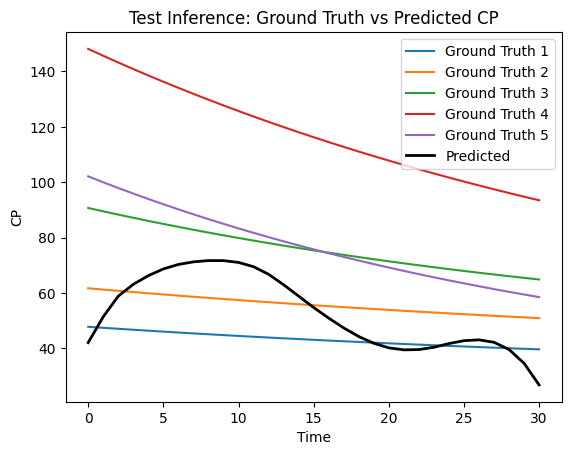

In [10]:
#############################
# 4. Main (학습 및 Inference 실행)
#############################
import os
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchdiffeq import odeint

# (이전 섹션에서 정의한 PKPDataset, collate_fn, NeuralODEModel, run_inference 등이 이미 import 또는 정의되어 있다고 가정)

mode_input = input(
    "모드를 선택하세요 (train, infer, test_train, test_infer 중 하나): "
).strip()
if mode_input not in ["train", "infer", "test_train", "test_infer"]:
    print("잘못된 입력입니다.")
    sys.exit(0)


class Args:
    pass


args = Args()
args.mode = mode_input
print(f"선택한 모드: {args.mode}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralODEModel().to(device)
checkpoint_path = "checkpoint.pth"
start_epoch = 0
loss_history = []

# 체크포인트가 있으면 불러옴 (학습 이어서 진행 가능)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    loss_history = checkpoint.get("loss_history", [])
    print(f"체크포인트 불러옴: epoch {start_epoch}부터 이어서 학습합니다.")

if torch.cuda.is_available():
    print(f"현재 사용 중인 GPU: {torch.cuda.get_device_name(0)}")
    print(f"사용 중인 GPU 메모리: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"예약된 GPU 메모리: {torch.cuda.memory_reserved() / 1024**2:.2f} MB\n")

if args.mode in ["train", "test_train"]:
    # 데이터셋 및 DataLoader 구성: test_train 모드이면 x행의 데이터만 사용 (= x명의 환자 데이터)
    if args.mode == "test_train":
        dataset = PKPDataset(
            parquet_path="../processed_data.parquet", max_files=5, max_rows=30
        )
    else:
        dataset = PKPDataset(parquet_path="../processed_data.parquet")

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = int(
        input(
            f"몇 epoch까지 학습할까요? 현재까지 학습된 epoch 수: {start_epoch} (학습 중간에 코드가 멈추더라도, 각 epoch가 끝날 때마다 자동으로 저장됩니다.) "
        )
        or 100
    )
    criterion = nn.MSELoss()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0
        if False:  # args.mode == "test_train" and (epoch % 10 != 0):
            iterator = dataloader  # tqdm 없이 진행
        else:
            iterator = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")

        for i, batch in enumerate(iterator, start=1):
            static_features = batch["static_features"].to(device)  # (B, 7)
            t = batch["t"].to(device)  # (T,)
            cp_target = batch["cp"].to(device)  # (B, T, 1)
            injection_times = batch["injection_times"].to(device)  # (B, n_events)
            injection_doses = batch["injection_doses"].to(device)  # (B, n_events)

            optimizer.zero_grad()
            cp_pred = model(
                t, static_features, injection_times, injection_doses
            )  # (B, T, 1)
            loss = criterion(cp_pred, cp_target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # 100 배치마다 진행상황 출력
            if i % 100 == 0:
                print(
                    f"Epoch {epoch}, Batch {i}/{len(dataloader)}: Current batch loss = {loss.item():.6f}",
                    flush=True,
                )

        epoch_loss /= len(dataloader)
        loss_history.append(epoch_loss)
        if args.mode == "train" or (args.mode == "test_train"):  # and epoch % 10 == 0):
            print(f"Epoch {epoch}: Average Loss = {epoch_loss:.6f}", flush=True)

        # 체크포인트 저장 (모델, 옵티마이저, epoch, loss history 포함)
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss_history": loss_history,
            },
            checkpoint_path,
        )

        # 체크포인트 저장 후, 각 epoch마다 CSV 파일 업데이트
        loss_df = pd.DataFrame(
            {"epoch": list(range(len(loss_history))), "loss": loss_history}
        )
        loss_df.to_csv("training_loss.csv", index=False)

        # 학습 loss 차트 그리기 및 저장
        plt.figure()
        plt.plot(loss_history, marker="o")
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (log scale)")
        plt.title("Training Loss History")
        plt.savefig("training_loss.png")
        plt.close()

    # 최종 loss 기록 CSV 저장
    loss_df = pd.DataFrame(
        {"epoch": list(range(len(loss_history))), "loss": loss_history}
    )
    loss_df.to_csv("training_loss.csv", index=False)
    print("학습 완료 및 loss 기록 저장됨.")

elif args.mode in ["infer", "test_infer"]:
    if args.mode == "test_infer":
        # 정적 특성은 사용자 입력으로 받음
        static_input = input(
            "BW, EGFR, SEX, RAAS, BPS, amt, II 값을 순서대로 입력하세요. (공백으로 구분, 예: 68.28 66.37 1 1 1 244 482): "
        )
        static_features = [float(x.strip()) for x in static_input.split()]
        # 첫 5개의 행(환자 데이터)에서 ground truth 데이터 불러오기
        dataset = PKPDataset(parquet_path="../processed_data.parquet", max_files=5)
        gt_list = []
        for sample in dataset:
            gt_time = sample["t"].numpy()
            gt_cp = sample["cp"].numpy().squeeze()  # (T,)
            gt_list.append((gt_time, gt_cp))
        print("첫 5개의 행의 CP 데이터가 로드되었습니다.")
    else:
        static_input = input(
            "BW, EGFR, SEX, RAAS, BPS, amt, II 값을 순서대로 입력하세요. (공백으로 구분, 예: 68.28 66.37 1 1 1 244 482): "
        )
        static_features = [float(x.strip()) for x in static_input.split()]

    total_time = float(input("모델이 예측할 총 시간을 입력하세요. (시간): "))

    amt = static_features[5]
    II = static_features[6]
    injection_times = np.arange(0, total_time + 1e-3, II, dtype=np.float32)
    injection_doses = np.full(injection_times.shape, amt, dtype=np.float32)

    pred_cp = run_inference(
        model, static_features, injection_times, injection_doses, total_time, device
    )

    if args.mode == "test_infer":
        # 예측된 CP와 동일한 시간 벡터 생성
        T_pred = len(pred_cp)
        pred_time = np.linspace(0, total_time, num=T_pred)
        plt.figure()
        # 첫 5개 행의 ground truth 데이터를 total_time 이하, 예측 길이에 맞게 자른 후 모두 플롯
        for idx, (gt_time, gt_cp) in enumerate(gt_list):
            mask = gt_time <= total_time
            gt_time_trim = gt_time[mask]
            gt_cp_trim = gt_cp[mask]
            gt_time_final = gt_time_trim[:T_pred]
            gt_cp_final = gt_cp_trim[:T_pred]
            plt.plot(gt_time_final, gt_cp_final, label=f"Ground Truth {idx+1}")
        plt.plot(pred_time, pred_cp, label="Predicted", linewidth=2, color="black")
        plt.xlabel("Time")
        plt.ylabel("CP")
        plt.title("Test Inference: Ground Truth vs Predicted CP")
        plt.legend()
        plt.savefig("test_inference_comparison.png")
        plt.show()